In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data.csv').replace('-', np.NaN).astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       2000 non-null   float64
 1   x       819 non-null    float64
 2   y       827 non-null    float64
dtypes: float64(3)
memory usage: 47.0 KB


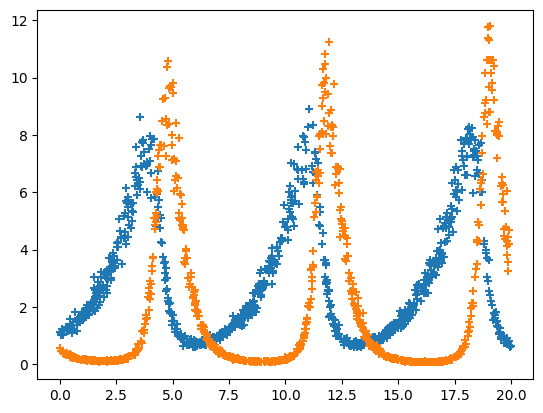

In [3]:
plt.scatter(x=df.t, y=df.x, marker='+')
plt.scatter(x=df.t, y=df.y, marker='+')
plt.show()

In [4]:
df_filled = df.interpolate(limit_direction='both')
df_filled

,t,x,y
0,0.00,1.115912,0.575905
1,0.01,1.115912,0.551311
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527
...,...,...,...
1995,19.95,0.611707,4.186361
1996,19.96,0.615469,4.186361
1997,19.97,0.619231,4.186361
1998,19.98,0.622993,4.186361


<AxesSubplot:xlabel='t'>

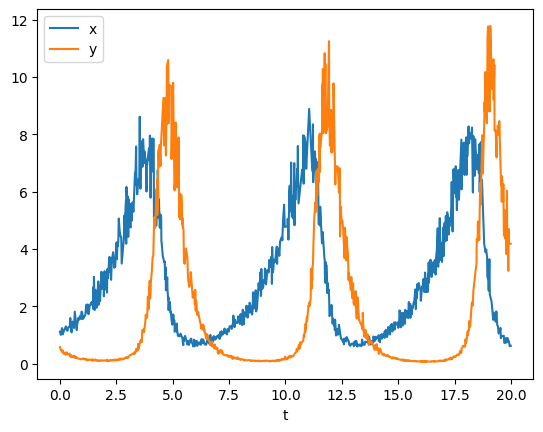

In [5]:
df_filled.plot(x='t', y=['x', 'y'])

# Linear NN

In [ ]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.num_layers = 2
        self.hidden_units = 16
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=self.hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )
        
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=2)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file).replace('-', np.NaN).astype(float)
        self.df_filled = self.df.interpolate(limit_direction='both')
        self.X = torch.tensor(df_filled[['t']].values)
        self.y = torch.tensor(df_filled[['x', 'y']].values)
        self.seq_l = 5

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if idx >= self.seq_l:
            i_start = idx - self.seq_l
            X = self.X[i_start:idx]
        else:
            padding = self.X[0].repeat(self.seq_l - idx, 1)
            X = self.X[0:idx]
            X = torch.cat((padding, X), 0)

        return X.float(), self.y[idx].float()

In [ ]:
BATCH_SIZE = 5

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# def loss_fn(outputs, labels):
#   #TODO

learning_rate = 0.01

loss_fn = nn.MSELoss()

net = Net()

# if torch.backends.mps.is_available():
#     device = torch.device('mps')
#     net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

In [ ]:
# Plot results to validate training
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

predictloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False)

pred = predict(predictloader, net)
pred

In [ ]:
plt.scatter(x=df.t, y=df.x, marker='+', linewidths=.5)
plt.scatter(x=df.t, y=df.y, marker='+', linewidths=.5)
plt.plot(df.t, pred)
plt.show()

# Time Series LSTM

In [16]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.num_layers = 1
        self.hidden_units = 32
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=self.hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )
        
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=2)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [17]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file).replace('-', np.NaN).astype(float)
        self.df_filled = self.df.interpolate(limit_direction='both')
        self.X = torch.tensor(self.df_filled[['t']].values)
        self.y = torch.tensor(self.df_filled[['x', 'y']].values)
        self.seq_l = 7

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if idx >= self.seq_l:
            i_start = idx - self.seq_l
            X = self.X[i_start:idx]
        else:
            padding = self.X[0].repeat(self.seq_l - idx, 1)
            X = self.X[0:idx]
            X = torch.cat((padding, X), 0)

        return X.float(), self.y[idx].float()

In [10]:
train = TimeSeriesDataset('data.csv')
X, y = train[4]
X, y

(tensor([[0.0000],
         [0.0000],
         [0.0100],
         [0.0200],
         [0.0300]]),
 tensor([1.0055, 0.4775]))

In [11]:
df_filled.head(9)

,t,x,y
0,0.00,1.115912,0.575905
1,0.01,1.115912,0.551311
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527
5,0.05,1.053657,0.468851
6,0.06,1.101832,0.460175
7,0.07,1.074546,0.465963
8,0.08,1.157007,0.471751


In [12]:
trainloader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(inputs)
    print(inputs.shape)
    print(labels)
    print(labels.shape)
    break

tensor([[[16.3700],
         [16.3800],
         [16.3900],
         [16.4000],
         [16.4100]],

        [[ 2.9600],
         [ 2.9700],
         [ 2.9800],
         [ 2.9900],
         [ 3.0000]],

        [[ 8.4900],
         [ 8.5000],
         [ 8.5100],
         [ 8.5200],
         [ 8.5300]],

        [[10.0500],
         [10.0600],
         [10.0700],
         [10.0800],
         [10.0900]],

        [[10.4600],
         [10.4700],
         [10.4800],
         [10.4900],
         [10.5000]]])
torch.Size([5, 5, 1])
tensor([[3.5674, 0.0676],
        [5.1455, 0.1950],
        [1.8488, 0.1018],
        [5.0525, 0.1898],
        [6.6634, 0.4378]])
torch.Size([5, 2])


In [18]:
BATCH_SIZE = 5

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# def loss_fn(outputs, labels):
#   #TODO

learning_rate = 0.01

loss_fn = nn.MSELoss()

net = Net()

# if torch.backends.mps.is_available():
#     device = torch.device('mps')
#     net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [19]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 7.915
[1,    40] loss: 6.012
[1,    60] loss: 6.848
[1,    80] loss: 7.438
[1,   100] loss: 7.297
[1,   120] loss: 6.149
[1,   140] loss: 5.852
[1,   160] loss: 4.359
[1,   180] loss: 6.681
[1,   200] loss: 6.134
[1,   220] loss: 6.495
[1,   240] loss: 6.136
[1,   260] loss: 7.804
[1,   280] loss: 5.693
[1,   300] loss: 5.680
[1,   320] loss: 5.213
[1,   340] loss: 5.726
[1,   360] loss: 6.573
[1,   380] loss: 6.380
[1,   400] loss: 5.167
[2,    20] loss: 6.146
[2,    40] loss: 5.924
[2,    60] loss: 5.266
[2,    80] loss: 5.566
[2,   100] loss: 5.596
[2,   120] loss: 4.169
[2,   140] loss: 5.061
[2,   160] loss: 5.272
[2,   180] loss: 5.680
[2,   200] loss: 5.053
[2,   220] loss: 4.510
[2,   240] loss: 4.692
[2,   260] loss: 4.938
[2,   280] loss: 3.666
[2,   300] loss: 3.237
[2,   320] loss: 4.990
[2,   340] loss: 4.942
[2,   360] loss: 5.242
[2,   380] loss: 4.535
[2,   400] loss: 5.103
[3,    20] loss: 4.465
[3,    40] loss: 4.380
[3,    60] loss: 5.019
[3,    80] 

In [20]:
# Plot results to validate training
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

predictloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False)

pred = predict(predictloader, net)
pred

tensor([[1.0785, 0.5549],
        [1.0785, 0.5549],
        [1.0844, 0.5451],
        ...,
        [0.7417, 4.0934],
        [0.7179, 4.0594],
        [0.6942, 4.0269]])

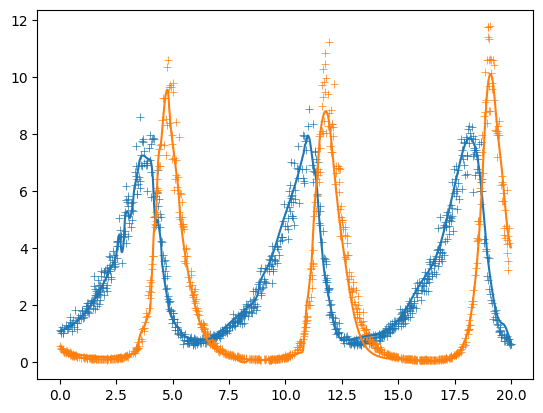

In [21]:
plt.scatter(x=df.t, y=df.x, marker='+', linewidths=.5)
plt.scatter(x=df.t, y=df.y, marker='+', linewidths=.5)
plt.plot(df.t, pred)
plt.show()

## Questions
Please answer the questions about the exercise below as a text cell. A few sentences answer per question is enough, no need to write a long essay.
  
- a) Roughly, how many parameters does the neural network you defined above have? How did you estimate that number?
- b) How does changing the batch size affect the optimization procedure?
- c) What optimizer did you choose and why? Explain its most important hyperparameters.
- d) What difficulties did you face when processing the dataset? How did you resolve them?
- e) How did you find the hyperparameters that gave you the best result? What would you have done if you had more time?
- f) In this exercise, we trained an MLP to regress the data from a single time point. This corresponds to assuming the source function is markovian. What would we do differently if the function under study were non-markovian?
- g) In this exercise, we did not check for overfitting. How would you change the code above to test for that possibility?
